In [1]:
'''Notebook to demonstrate how to train scikit-learn models and use them to make predictions'''

'Notebook to demonstrate how to train scikit-learn models and use them to make predictions'

In [15]:
# As usual, read in data
import pandas as pd
df = pd.read_csv('sample_tweets.csv', encoding='iso-8859-1')

# For demo purposes, let's take a smaller random subset
subset = df.sample(n=1000)

# Make sure we still have a reasonable distribution
subset.groupby('polarity').count()

,text
polarity,
0,513
4,487


In [16]:
# Isolate target and tweets
target = subset.polarity
tweets = subset.text

In [120]:
# Exract features as before
from stop_words import get_stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

mention = r'^(.*\s)?@\w+'
hashtag = r'^(.*\s)?#\w+'
url = r'^((http[s]?|ftp):\/)?\/?([^:\/\s]+)((\/\w+)*\/)([\w\-\.]+[^#?\s]+)(.*)?(#[\w\-]+)?$'

def extract_features(tweet_data):
    stop_words = set(get_stop_words('en'))
    
    def preprocess(word):
        return word.replace(mention, '').replace(hashtag, '').replace(url, '')
    
    # Get counts
    word_vectorizer = CountVectorizer(ngram_range=(1, 3), analyzer='word', preprocessor=preprocess, stop_words=stop_words)
    word_doc_matrix = word_vectorizer.fit_transform(tweet_data)
    
    # Get tf-idf
    tfidf_transformer = TfidfTransformer(use_idf=True)
    word_doc_tfidf_matrix = tfidf_transformer.fit_transform(word_doc_matrix)
    return word_doc_tfidf_matrix, word_vectorizer, tfidf_transformer

features, word_vectorizer, tfidf_transformer = extract_features(tweets)

In [23]:
# It's easy to build a model with scikit-learn 
from sklearn.naive_bayes import GaussianNB

# The model
model = GaussianNB()

# Train the model to build a classifier
classifier = model.fit(features.toarray(), target)

In [24]:
# Now let's take a tweet and make a prediction!
# ---> Ask class to go on twitter and pick pos/neg/neutral tweet
positive_tweet = 'I know its against the rules, but I wish Trump could be Prez for the rest of his life... then pass it on to one of his amazing kids!'
negative_tweet = 'I found so many of Trumps comments to be deeply abhorrent'

In [125]:
# Create prediction function
def predict_sentiment(clf, word_vec, tfidf, tweets):
    # First we'll want to get the tweet into the same format
    # as the features the model was trained on.
    counts = word_vec.transform(tweets)
    tfidfs = tfidf.transform(counts)
    predictions = clf.predict(tfidfs.toarray())
    return predictions

In [126]:
predict_sentiment(classifier, word_vectorizer, tfidf_transformer, [positive_tweet])[0]

4

In [127]:
predict_sentiment(classifier, word_vectorizer, tfidf_transformer, [negative_tweet])[0]

0

In [128]:
# Cool! It works! 

In [129]:
# But it's too difficult to manually go through a bunch of examples
# and see if they make sense. We want to quickly assess model performance.
# Let's take a sample of tweets from our data and make predictions on
# them and see how closely they line up.
test_tweets = df.sample(n=500)
test_tweets.head(10)

,polarity,text
297,0,@KourtneyKardash yup night workouts r the wors...
7696,4,@G2Trading Glad $YGE worked out for you! After...
2667,0,"Is still sick, hate this"
4098,0,wants gtalk on my phone.. haha.
5535,4,"Lines, Vines, and Trying Times TODAY!!!!!"
2343,0,finished everything she needs to do at work to...
7074,4,Ate lunch today with the mysterious karkumatka...
5268,4,@hollyhood Without a doubt
2578,0,@robertzalme Yes I do... Too much theory getti...
8290,4,@aquasulis i finally found a good image which...


In [130]:
test_predictions = predict_sentiment(classifier, word_vectorizer, tfidf_transformer, test_tweets.text)
test_predictions[:10]

array([4, 0, 4, 0, 4, 0, 0, 0, 0, 4])

In [131]:
# Model evaluation method 1: accuracy
from sklearn.metrics import accuracy_score

# Manually compute this on the top 10:
# Number correct = 4
# Total = 10
# Accuracy = 4/10 = 0.4 = worse than guessing!

accuracy_score(test_tweets.polarity, test_predictions)

0.68999999999999995

In [132]:
# This is better than guessing, but not great. 
# But we don't have a lot of data at this point.
# Models do tend to improve with more data. There
# are also other metrics we can use -- like we 
# mentioned before, accuracy can sometimes be misleading.
# Let's try AUC.
from sklearn.metrics import roc_auc_score

# AUC only accepts boolean attributes
roc_auc_score(test_tweets.polarity == 4, test_predictions == 4)

0.68419363122752952

In [133]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(test_tweets.polarity, test_predictions)

# Number of true positives (they were happy, and we predicted happy)
TP = confusion_mat[1][1]

# Number of true negatives (they were not happy, and we predicted sad)
TN = confusion_mat[0][0]

# Number of false positives (they were sad, but we predicted happy)
FP = confusion_mat[0][1]

# Number of false negatives (they are happy, but we predicted sad)
FN = confusion_mat[1][0]

print('True positives:', TP)
print('True negatives:', TN)
print('False positives:', FP)
print('False negatives:', FN)

True positives: 208
True negatives: 137
False positives: 99
False negatives: 56


In [134]:
# We are better at predicting happy than sad -- this is encoded by the TP rate
# I.e., How often are we correct when the tweet is happy?
TP_rate = TP / (TP + FN)
TP_rate

0.78787878787878785

In [135]:
# We are less good at predicting sad -- this is encoded by the FP rate
# I.e., how often are we getting it wrong when the tweet is sad?
FP_rate = FP / (TN + FP)
FP_rate

0.41949152542372881

In [136]:
# Ideally, we want a TP_rate of 100% (i.e., we correctly predict all the ones that are happy)
# and a FP rate of 0% (i.e, we are never wrong in our predictions when they are sad).
# We can plot these two against each other -- TP rate on y-axis, and FP rate on x-axis.
# If we want TP_rate = 1 and FP_rate = 0, that means the point on the top left of the chart is the ideal.

# AUC = Area Under the Curve = area between top left point and bottom right point, i.e., the area of the chart.
# We have an AUC of 1x1 = 1 units with a perfect classifier

# Also want a steep curve, since we want to maximize TP_rate and minimize FP_rate.

# The ROC curve is the name of the chart that plots TP_rate vs. FP_rate
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt
%matplotlib inline

fp_rate, tp_rate, _ = roc_curve(test_tweets.polarity == 4, test_predictions == 4)

# Confirm what we had manually calculated
fp_rate, tp_rate, auc

(array([ 0.        ,  0.41949153,  1.        ]),
 array([ 0.        ,  0.78787879,  1.        ]),
 0.64460547504025756)

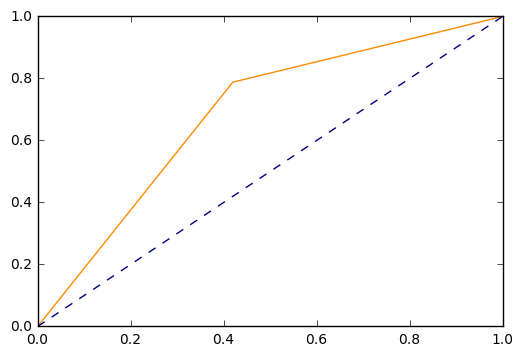

In [137]:
# Plot 
plt.figure()
plt.plot(fp_rate, tp_rate, color='darkorange')
plt.plot([0,1], [0,1], color='navy', linestyle='--')

In [193]:
# Turn this into a function
def plot_roc(pred, actual):
    fp_rate, tp_rate, _ = roc_curve(pred == 4, actual == 4)
    print('FP rate:', fp_rate)
    print('TP rate:', tp_rate)
    plt.figure()
    plt.plot(fp_rate, tp_rate, color='darkorange')
    plt.plot([0,1], [0,1], color='navy', linestyle='--')

In [138]:
# IF WE HAVE TIME: EXTRACTING PROBABILITIES AND LIFT CHART

In [139]:
# You can use other scikit-learn models in exactly the same way.
# We briefly discussed the following:
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

# You should all start running decision trees and/or SVMs
# as we go over the rest of the lecture, as they take a 
# bit of time to complete.

In [140]:
# EVERYONE STOP! WE'VE MADE A HUGE MISTAKE!
# Can anyone guess what it was?
# (They should be able to; went over it in the lecture)

In [163]:
# We tested on our training data. We NEVER want to do this! 
# Instead, we want to use a holdout set or cross-validation
# to assess model performance. This will give us a better
# notion of how the model will perform out in the wild and
# avoid overfitting (memorizing the data).

## TODO: split into train/validation first

In [165]:
# Reindex data (we were using a subset, so indices will be messed up)
tweets = pd.Series(list(tweets))
target = pd.Series(list(target))
tweets.size, target.size

(1000, 1000)

In [166]:
# Let's partition our data into 5 different sections, or folds
from sklearn.model_selection import KFold

# This gives us the indices needed to split the actual data
folds = KFold(n_splits=5).split(tweets)

# Returns generator, so convert to list
folds = list(folds)

# For each fold, we're going to split our data into a training
# set (on which we train the model), and a test set (on which
# we test the model by making predictions)
def split_data(train_folds, test_folds):
    train_X = tweets[train_folds]
    train_Y = target[train_folds]
    test_X = tweets[test_folds]
    test_Y = target[test_folds]
    return train_X, train_Y, test_X, test_Y

In [167]:
# Let's look at an example
train, test = folds[0]
train.size, test.size

(800, 200)

In [168]:
train_X, train_Y, test_X, test_Y = split_data(train, test)

In [169]:
assert train_X.size == train_Y.size

In [170]:
assert test_X.size == test_Y.size

In [177]:
train_X.head(10), train_Y.head(10)

(200    Just checked my user timeline on my blackberry...
 201    Dance Recitals are so stressing but I love eve...
 202    Working at uni.. Red Bull and a packet of sult...
 203    women who love power tools unite!!! Refinishin...
 204    @Rockchic65 I normally go with pumpkin patch, ...
 205    @yasminkaye Do it!! Don't be grumpy though, th...
 206                                      C'mon sean man 
 207    To transcode a 100MB .wmv to a 100MB .flv file...
 208    @meganh93 same it has been drizzling all day  ...
 209    @huntermoore I don't want him to ever punch me.  
 dtype: object, 200    0
 201    4
 202    0
 203    4
 204    0
 205    0
 206    0
 207    0
 208    0
 209    0
 dtype: int64)

In [194]:
# For each fold, we're going to train a model
# on the training portion of the fold and then
# test it on the testing portion of the fold.
def train_and_test(model, train_X, train_Y, test_X, test_Y):
    # Learn features from training data
    train_features, word_vectorizer, tfidf_transformer = extract_features(train_X)
    
    # Train model and build classifier
    clf = model().fit(train_features.toarray(), train_Y)
    
    # Make predictions
    predictions = predict_sentiment(clf, word_vectorizer, tfidf_transformer, test_X)
    
    # Return score information
    scores = {
        'accuracy': accuracy_score(predictions, test_Y),
        'auc': roc_auc_score(predictions == 4, test_Y == 4),
        'roc_curve': roc_curve(predictions == 4, test_Y == 4),
        'confusion': confusion_matrix(predictions, test_Y)
    }
    return scores, predictions

In [195]:
# Let's go through this procedure for one of the folds
train_X, train_Y, test_X, test_Y = split_data(train, test)
scores, predictions = train_and_test(GaussianNB, train_X, train_Y, test_X, test_Y)

In [196]:
scores['accuracy']

0.64500000000000002

In [197]:
scores['auc']

0.64513061755580015

FP rate: [ 0.         0.3592233  1.       ]
TP rate: [ 0.          0.64948454  1.        ]


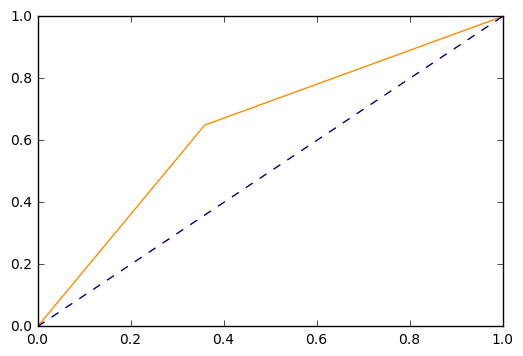

In [199]:
plot_roc(predictions, test_Y)

In [203]:
# Now we can repeat this for all folds.
# Let's find the average accuracy across all folds
fold_accuracies = []

# For each fold
for fold in folds:
    # Get train/test partitions
    train_X, train_Y, test_X, test_Y = split_data(train, test)
    
    # Train and test
    scores, predictions = train_and_test(GaussianNB, train_X, train_Y, test_X, test_Y)
    
    fold_accuracies.append(scores['accuracy'])

# Our classes are balanced so accuracy is an ok metric
# However, we don't know the distribution of sentiment
# in the wild, so we don't know if this is actually an
# ok metric if we want to use the model to make predictions
# in the wild.
print('Average accuracy:', sum(fold_accuracies) / len(fold_accuracies))

Average accuracy: 0.645


In [ ]:
# DONE MODELING!
# Now try this on your own with MORE data!

In [216]:
# PS - let's save our model and featurizers so we can use them later

# Create wrapper class for model parts that we can pickle
class Model:
    def __init__(self, classifier, word_vectorizer, tfidf_transformer):
        self.classifier = classifier
        self.word_vectorizer = word_vectorizer
        self.tfidf_transformer = tfidf_transformer
    
    def predict(self, tweets):
      counts = self.word_vectorizer.transform(tweets)
      tfidfs = self.tfidf.transform(counts)
      predictions = self.classifier(tfidfs.toarray())
      return predictions

In [217]:
gaussian_model = Model(classifier, word_vectorizer, tfidf_transformer)

In [218]:
# Pickle is an object serialization module that allows us to
# serialize, or convert to a byte stream, a python object
import pickle
# pickle.dump(gaussian_model, open('models/gaussian_model.pkl', 'wb'))